<a href="https://colab.research.google.com/github/sjamthe/ragalearner/blob/main/Song_Notes_Parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This parses audio data from a video from YouTube, then splits audio to get vocals and parses the vocals to get the fundamental **frequencies**

## 1. Connect to GDrive - Repository for music *storage*

In [17]:
# Check is Link to Drive is OK
google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
if (google[0] == '0' ):
  from google.colab import drive
  drive.mount('/content/GDrive/',force_remount=True)
!if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi
GDRIVE_TMP = '/content/GDrive/MyDrive/ragalearner'
!if [ -d {GDRIVE_TMP} ]; then echo "Output to be stored in "{GDRIVE_TMP} ; else mkdir -p {GDRIVE_TMP} && echo "Output directory created"; fi


Connection to Google drive successful
Output to be stored in /content/GDrive/MyDrive/ragalearner


In [18]:
#@title Useful functions, don't forget to execute
import io
from pathlib import Path
import select
from shutil import rmtree
import subprocess as sp
import sys
from typing import Dict, Tuple, Optional, IO

from google.colab import files

def find_files(in_path):
    out = []
    for file in Path(in_path).iterdir():
        if file.suffix.lower().lstrip(".") in extensions:
            out.append(file)
    return out

def copy_process_streams(process: sp.Popen):
    def raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
        assert stream is not None
        if isinstance(stream, io.BufferedIOBase):
            stream = stream.raw
        return stream

    p_stdout, p_stderr = raw(process.stdout), raw(process.stderr)
    stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
        p_stdout.fileno(): (p_stdout, sys.stdout),
        p_stderr.fileno(): (p_stderr, sys.stderr),
    }
    fds = list(stream_by_fd.keys())

    while fds:
        # `select` syscall will wait until one of the file descriptors has content.
        ready, _, _ = select.select(fds, [], [])
        for fd in ready:
            p_stream, std = stream_by_fd[fd]
            raw_buf = p_stream.read(2 ** 16)
            if not raw_buf:
                fds.remove(fd)
                continue
            buf = raw_buf.decode()
            std.write(buf)
            std.flush()

def separate(inp=None, outp=None):
    inp = inp or in_path
    outp = outp or out_path
    cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", model]
    if mp3:
        cmd += ["--mp3", f"--mp3-bitrate={mp3_rate}"]
    if float32:
        cmd += ["--float32"]
    if int24:
        cmd += ["--int24"]
    if two_stems is not None:
        cmd += [f"--two-stems={two_stems}"]
    files = [str(f) for f in find_files(inp)]
    if not files:
        print(f"No valid audio files in {in_path}")
        return
    print("Going to separate the files:")
    print('\n'.join(files))
    print("With command: ", " ".join(cmd))
    p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
    copy_process_streams(p)
    p.wait()
    if p.returncode != 0:
        print("Command failed, something went wrong.")


def from_upload():
    out_path = Path('separated')
    in_path = Path('tmp_in')

    if in_path.exists():
        rmtree(in_path)
    in_path.mkdir()

    if out_path.exists():
        rmtree(out_path)
    out_path.mkdir()

    uploaded = files.upload()
    for name, content in uploaded.items():
        (in_path / name).write_bytes(content)
    separate(in_path, out_path)


## 2. Select stream and download Audio to GDrive

In [ ]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
url = input("Enter Youtube url for music: ")

Enter Youtube url for music: https://www.youtube.com/watch?v=OC-E1bNTcP8&list=RDOC-E1bNTcP8&start_radio=1


In [ ]:
from pytube import YouTube

#url = "https://www.youtube.com/watch?v=6b6uhHbGAXQ"
yt = YouTube(url)
streams = yt.streams
# show all available audio streams (we can select first or anyone we want later)
streams.filter(only_audio=True)

[<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">, <Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2" progressive="False" type="audio">, <Stream: itag="249" mime_type="audio/webm" abr="50kbps" acodec="opus" progressive="False" type="audio">, <Stream: itag="250" mime_type="audio/webm" abr="70kbps" acodec="opus" progressive="False" type="audio">, <Stream: itag="251" mime_type="audio/webm" abr="160kbps" acodec="opus" progressive="False" type="audio">]

In [ ]:
#confirm we have a 720p stream with progressive=True
stream = streams.filter(only_audio=True).first()
stream

<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">

In [ ]:
#if above is not null download the stream else select progressive=False and try
audio = stream.download(GDRIVE_TMP)

## 3. Split/Demix audio into main melody and supporting music tracks

In [ ]:
!python3 -m pip install -U git+https://github.com/facebookresearch/demucs#egg=demucs

In [20]:
# Customize the following options!
model = "htdemucs" # latest model
# model = "mdx_extra_q" # older model
extensions = ["mp4", "mp3", "wav", "ogg", "flac"]  # we will look for all those file types.
# two_stems = None   # only separate one stems from the rest, for instance
two_stems = "vocals"

# Options for the output audio.
mp3 = False
mp3_rate = 320
float32 = False  # output as float 32 wavs, unsused if 'mp3' is True.
int24 = False    # output as int24 wavs, unused if 'mp3' is True.
# You cannot set both `float32 = True` and `int24 = True` !!

in_path = str(GDRIVE_TMP) + '/demucs/'
out_path = str(GDRIVE_TMP) + '/demucs_separated/'

In [21]:
# show input files
for file in Path(in_path).iterdir():
  print (file)

/content/GDrive/MyDrive/ragalearner/demucs/yaman practice for jab deep.mp3
/content/GDrive/MyDrive/ragalearner/demucs/Mujh Se Pehli Si Mohabbat  Sniti Mishra  Noor Jahan  Faiz A Faiz   Urdu Nazm.mp4
/content/GDrive/MyDrive/ragalearner/demucs/Ranjish hi sahi Mehdi Hassan.mp3


In [24]:
# separate file name to get song title
import os
filename = os.path.basename(file)
songname, ext = filename.split(".")
songname

'Ranjish hi sahi Mehdi Hassan'

In [25]:
songname = "yaman practice for jab deep"

In [ ]:
# This can be quite slow, in particular the loading, and saving from GDrive. Please be patient!
# This is from google drive! Also, this will separate all the files inside the MyDrive/demucs folder,
# so when you are happy with the results, remove the songs from there.
separate() # WARNING This seperates all files in demucs folder. make sure to clean it.

In [27]:
# show output files
for file in Path(out_path + "/htdemucs/").iterdir():
  if file.is_dir:
    for file2 in Path(file).iterdir():
      print (file2)

/content/GDrive/MyDrive/ragalearner/demucs_separated/htdemucs/Mujh Se Pehli Si Mohabbat  Sniti Mishra  Noor Jahan  Faiz A Faiz   Urdu Nazm/vocals.wav
/content/GDrive/MyDrive/ragalearner/demucs_separated/htdemucs/Mujh Se Pehli Si Mohabbat  Sniti Mishra  Noor Jahan  Faiz A Faiz   Urdu Nazm/no_vocals.wav
/content/GDrive/MyDrive/ragalearner/demucs_separated/htdemucs/Ranjish hi sahi Mehdi Hassan/vocals.wav
/content/GDrive/MyDrive/ragalearner/demucs_separated/htdemucs/yaman practice for jab deep/vocals.wav
/content/GDrive/MyDrive/ragalearner/demucs_separated/htdemucs/yaman practice for jab deep/no_vocals.wav


In [28]:
# create vocals file name from songname
vocals = out_path + "/htdemucs/" + songname + '/vocals.wav'
vocals

'/content/GDrive/MyDrive/ragalearner/demucs_separated//htdemucs/yaman practice for jab deep/vocals.wav'

In [29]:
#play the vocals to see if it is fine.
import librosa
from IPython.display import Audio

y,sr = librosa.load(vocals)

In [30]:
Audio(filename=vocals)

In [31]:
sr

22050

## 4. Extract frequency from the wave file

### Using [pYAAPT](https://bjbschmitt.github.io/AMFM_decompy/pYAAPT.html)

In [11]:
! pip install AMFM-decompy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.5/751.5 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for AMFM-decompy: filename=AMFM_decompy-1.0.11-py3-none-any.whl size=42835 sha256=ccdc10aaf673f830ecb0d3393ad5a0012fd949fe099f5487ee7afd802536cfe4
  Stored in directory: /root/.cache/pip/wheels/07/81/e7/443ad333f2f4ed8c06fc027caeb0d0c84b896fe7e56c2e92b1
Successfully built AMFM-decompy


In [12]:
out_path = str(GDRIVE_TMP) + '/demucs_separated/'
file = out_path + "htdemucs/Mujh Se Pehli Si Mohabbat  Sniti Mishra  Noor Jahan  Faiz A Faiz   Urdu Nazm/vocals.wav"
file

'/content/GDrive/MyDrive/ragalearner/demucs_separated/htdemucs/Mujh Se Pehli Si Mohabbat  Sniti Mishra  Noor Jahan  Faiz A Faiz   Urdu Nazm/vocals.wav'

In [13]:
import amfm_decompy.pYAAPT as pYAAPT
import amfm_decompy.basic_tools as basic

signal = basic.SignalObj(file)
time_stamp_in_secs = signal.size/signal.fs

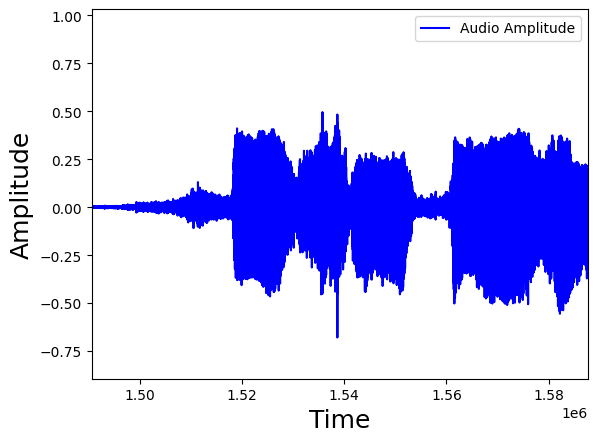

In [14]:
from matplotlib import pyplot as plt
plt.plot(signal.data, label='Audio Amplitude', color='blue')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.legend(loc='upper right')
axes = plt.gca()
start_secs = 33.8
end_secs = 36
axes.set_xlim([start_secs*signal.fs,end_secs*signal.fs])
plt.show()

In [15]:
from IPython.display import Audio

start = int(start_secs*signal.fs)
end = int(end_secs*signal.fs)
data = signal.data[start:end]
Audio(data,rate=signal.fs)

In [70]:
start

1455300

In [19]:
pitch = pYAAPT.yaapt(signal)

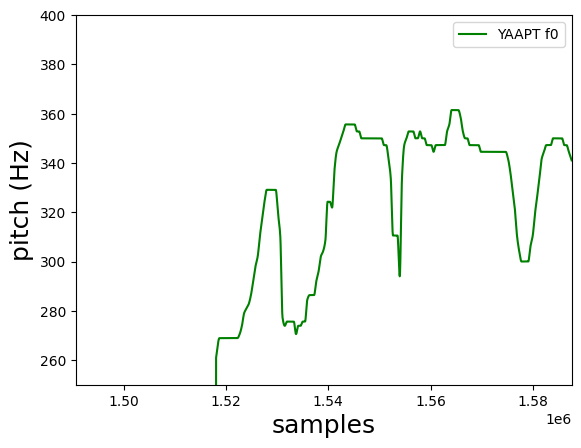

In [20]:
from matplotlib import pyplot as plt

plt.plot(pitch.values, label='YAAPT f0', color='green')

plt.xlabel('samples', fontsize=18)
plt.ylabel('pitch (Hz)', fontsize=18)
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([start_secs*signal.fs,end_secs*signal.fs])
axes.set_ylim([250,400])

plt.show()

In [21]:
# Downsample the pitch returned by YAAPT to only 1 reading every 10ms to match CREPE data
import numpy as np
pitches_per_sample = int(signal.fs/100) # number of pitches to average per 10ms (441)

#original array
original_array = np.array(pitch.values)
# we need to increase the size with 0 padding on the array so it divisible by pitches_per_sample
new_size = np.round(original_array.size/pitches_per_sample)* pitches_per_sample
padding_size = int(new_size - original_array.size)

# Create a new array with the desired shape and fill it with padding values
padded_array = np.concatenate((original_array, np.zeros(padding_size)))

# Reshape the original array into a 2D array
reshaped_array = padded_array.reshape(-1, pitches_per_sample)

# Calculate the average along the second axis (axis=1) to get the average of each row
averages = np.mean(reshaped_array, axis=1)

# The 'averages' array will contain the averages of consecutive 10 elements
print(reshaped_array.shape, averages.shape)


(22677, 441) (22677,)


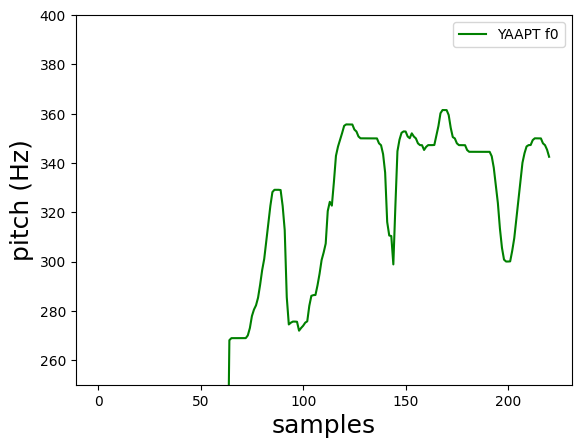

In [22]:
from matplotlib import pyplot as plt

start_p = int(start_secs*100)
end_p = int(end_secs*100)

new_pitch = averages[start_p:end_p]
plt.plot(new_pitch, label='YAAPT f0', color='green')

plt.xlabel('samples', fontsize=18)
plt.ylabel('pitch (Hz)', fontsize=18)
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_ylim([250,400])

plt.show()

### Using [CREPE](https://github.com/marl/crepe)

In [ ]:
# ! pip install --upgrade tensorflow  # if you don't already have tensorflow >= 2.0.0
! pip install crepe

In [34]:
import crepe

time, frequency, confidence, _ = crepe.predict(audio=y, sr=sr, viterbi=True)


114/114 [==============================] - 140s 1s/step


In [35]:
import pandas as pd
# Create a Pandas array
array = pd.DataFrame({'Time': time, 'Frequency': frequency, 'Confidence': confidence })

# Save the array to a file
datafile = GDRIVE_TMP + '/data/' + songname + '.csv'
array.to_csv(datafile, index=True)

In [36]:
frequency.size

3623

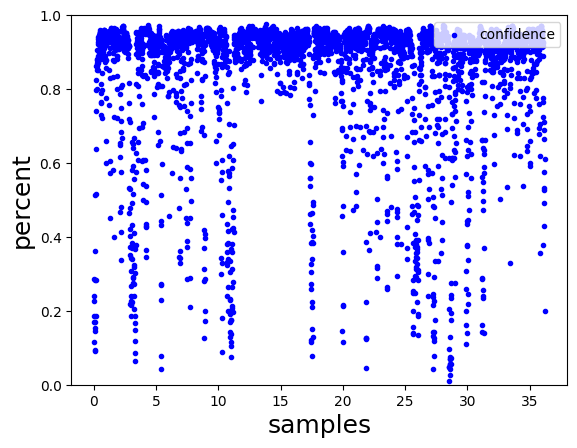

In [37]:
from matplotlib import pyplot as plt

#plt.plot(confidence, label='CREPE confidence', color='magenta')
plt.scatter(time, confidence, marker='.', color='b', label='confidence')


plt.xlabel('samples', fontsize=18)
plt.ylabel('percent', fontsize=18)
plt.legend(loc='upper right')
axes = plt.gca()
#axes.set_xlim()
axes.set_ylim([0,1])

plt.show()

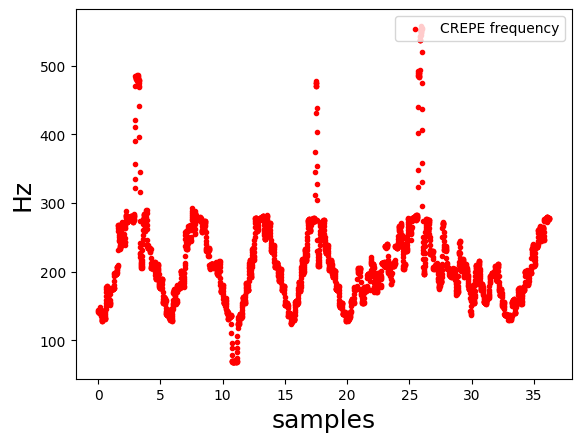

In [39]:
from matplotlib import pyplot as plt

#plt.plot(frequency, label='CREPE frequency', color='green')
#plt.plot(clean_freq, label='Clean frequency', color='pink')
plt.scatter(time, frequency, marker='.', color='r', label='CREPE frequency')

plt.xlabel('samples', fontsize=18)
plt.ylabel('Hz', fontsize=18)
plt.legend(loc='upper right')
axes = plt.gca()
#axes.set_xlim([50,60])
#axes.set_xlim()

plt.show()

## Convert Frequency to Notes

### Library functions to convert frequency to cents and notes

In [178]:
from operator import add
#functions
FREQ_A1 = 55.0
FREQ_B1 = FREQ_A1*2**(2/12)
FREQ_C2 = FREQ_A1*2**(3/12)
FREQ_D2 = FREQ_A1*2**(5/12)
reference_frequency = FREQ_B1

def freq_to_cents(frequency):
  cents =  1200 * np.log2(frequency / reference_frequency )
  cents[frequency<reference_frequency] = 0
  return cents

def cents_to_freq(cents):
  return reference_frequency*np.power(2, cents/1200.0)

def cents_to_perfect_cents(cents):
  return np.round(cents/100)*100

NOTES = ["C", "Db", "D", "Eb", "E", "F", "F#", "G", "Ab", "A", "Bb", "B"]
ALL_NOTES = np.empty(60, dtype = '<U3')
i = 0
for octave in [2,3,4,5,6]:
  for note in NOTES:
    ALL_NOTES[i] = note+str(octave)
    i = i + 1

SPACE = "_sp"
#octaves 2 to 6 ie C2 to B6
def cents_to_octave_notes(cents):
  #convert cents to perfect cents first.
  perfect_cents = cents_to_perfect_cents(cents)
  octave_notes = np.empty(perfect_cents.size, dtype = '<U3') #3 characters max

  #mark spaces
  octave_notes[perfect_cents < 100] = SPACE
  cent = 0 # start
  for octave in [2,3,4,5,6]:
    for note in NOTES:
      cent = cent + 100
      octave_notes[perfect_cents == cent] = note+str(octave)
      #print("mapping " + str(cent) + " to " + note+str(octave))
  return octave_notes


In [176]:
# TEST cents_to_octave_notes
cents_to_octave_notes(np.array([0.0, 104.0, 200.0, 0.0, 0.0, 1220.0, 1300.0, 0.0, 2600.0, 0.0]))

array(['_sp', 'C2', 'Db2', '_sp', '_sp', 'B2', 'C3', '_sp', 'Db4', '_sp'],
      dtype='<U3')

In [85]:
#TEST
testfreq = np.array([FREQ_C2, FREQ_C2*1.2, 2*FREQ_C2])
cents = freq_to_cents(testfreq)
print (testfreq, cents)

[ 65.40639133  78.48766959 130.81278265] [ 100.        415.641287 1300.      ]


In [86]:
#TEST
cents_to_freq(cents)

array([ 65.40639133,  78.48766959, 130.81278265])

In [16]:
# test above function
octave_freq = [FREQ_C2, 2*FREQ_C2, 4*FREQ_C2, 8*FREQ_C2, 16*FREQ_C2, 32*FREQ_C2]
octaves = freq_to_cents(np.array(octave_freq))
octaves

array([ 100., 1300., 2500., 3700., 4900., 6100.])

### Load frequency data from file created by CREPE

In [40]:
# load data file
import pandas as pd

songname = "yaman practice for jab deep"
datafile = GDRIVE_TMP + '/data/' + songname + '.csv'
array = pd.read_csv(datafile, index_col=[0])

In [41]:
# TEST / VERIFY
array.head()

Time   Frequency  Confidence
0  0.00  143.676940    0.226377
1  0.01  141.802695    0.115504
2  0.02  141.984996    0.185792
3  0.03  141.947158    0.285077
4  0.04  140.890036    0.240086

### Clean up frequency and convert to perfect cents and octave notes

In [ ]:
## Clean frequency with confidence > 0.6
import numpy as np
time = array.Time
clean_freq = np.array(array.Frequency)
clean_freq[array.Confidence < 0.6] = 1 #don't make is 0 as we cannot do log2 of 0

In [ ]:
# TEST / VERIFY
time.size, clean_freq.size

(3623, 3623)

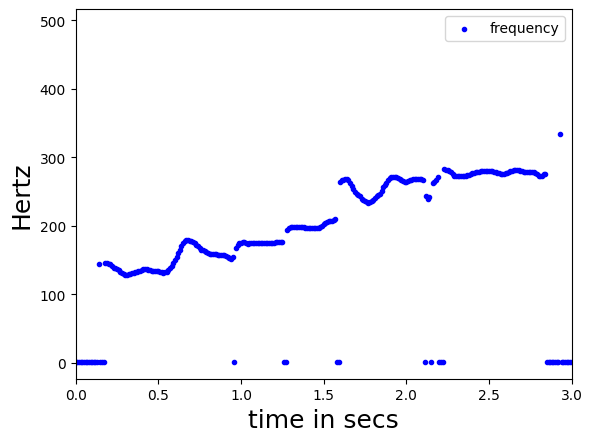

In [ ]:
# TEST / VERIFY - plot the clean frequency against time

from matplotlib import pyplot as plt

plt.scatter(time, clean_freq, marker='.', color='b', label='frequency')


plt.xlabel('time in secs', fontsize=18)
plt.ylabel('Hertz', fontsize=18)
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim(0,3)
#axes.set_ylim([100,340])

plt.show()

In [168]:
#convert clean_freq from file to cents and perfect_cents and octave_notes
cents = freq_to_cents(clean_freq)
perfect_cents = cents_to_perfect_cents(cents)
octave_notes = cents_to_octave_notes(cents)

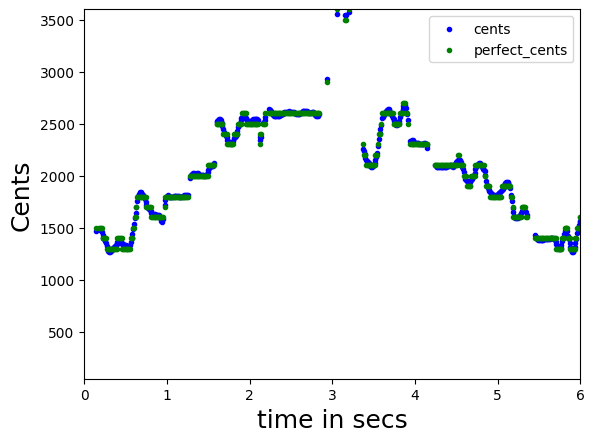

In [169]:
#TEST plot some cents and perfect_cents to get a feel for the data
from matplotlib import pyplot as plt

plt.scatter(time, cents, marker='.', color='b', label='cents')
plt.scatter(time, perfect_cents, marker='.', color='g', label='perfect_cents')


plt.xlabel('time in secs', fontsize=18)
plt.ylabel('Cents', fontsize=18)
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim(0,6)
axes.set_ylim([50,3600])

plt.show()

In [170]:
#TEST at time t show all values
t = 250
time[t],clean_freq[t],cents[t],perfect_cents[t],octave_notes[t]

(2.5, 279.7241073519789, 2615.80128476521, 2600.0, 'Db4')

In [190]:
unique_notes = np.unique(octave_notes)
# Create a dictionary to store the number of occurrences of each unique value
note_counts = {}
for note in ALL_NOTES:
    note_counts[note] = np.count_nonzero(octave_notes == note)

In [188]:
unique_notes

array(['A3', 'Ab2', 'Ab3', 'B2', 'B3', 'B4', 'Bb2', 'Bb3', 'Bb4', 'C3',
       'C4', 'D3', 'D4', 'Db2', 'Db3', 'Db4', 'E3', 'E4', 'Eb3', 'F#3',
       'F3', 'G2', 'G3', '_sp'], dtype='<U3')

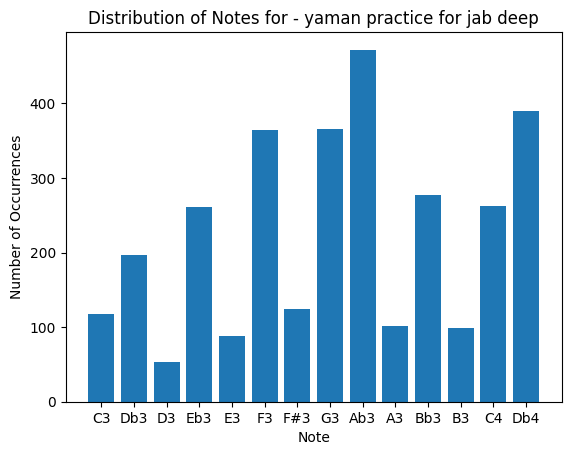

In [218]:
# Create a bar chart after filtering our notes that have very low value
filter_below = 15
dict_values = note_counts.values()
all_values = np.array(list(dict_values))
y = all_values[all_values > filter_below]
x = ALL_NOTES[all_values > filter_below]
plt.bar(x, y)

# Set the title and labels of the bar chart
plt.title("Distribution of Notes for - " + songname)
plt.xlabel("Note")
plt.ylabel("Number of Occurrences")

# Show the bar chart
plt.show()